<a href="https://colab.research.google.com/github/jaysulk/uic_fnal_linac_phase_comp/blob/Sulskis-dev/PyTorch_Longitudinal_correction_with_AFNO_(SANDBOXING).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.fft as spft
from sklearn.linear_model import LinearRegression

ModuleNotFoundError: No module named 'afno'

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
# Skip the below if already installed
!pip install einops timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
if not os.path.exists("/content/AFNO-transformer"):
    !git clone https://github.com/NVlabs/AFNO-transformer.git /content/AFNO-transformer
    !pip install /content/AFNO-transformer/

Cloning into '/content/AFNO-transformer'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 123 (delta 4), reused 4 (delta 4), pack-reused 117 (from 1)
Receiving objects: 100% (123/123), 75.59 MiB | 30.51 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Processing /content/AFNO-transformer
  Preparing metadata (setup.py) ... done
  Created wheel for afno: filename=afno-0.0.1-py3-none-any.whl size=16102 sha256=645480409797e329553a62bc3c86ecb59efe5190be824b440ad06dae0ce58848
  Stored in directory: /root/.cache/pip/wheels/f7/ee/29/5fc1159e52321657da07c95d984c4700391881462ab171d935
Successfully built afno


In [ ]:
from afno import AFNO1D,AFNO2D

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
def fetch_data(file,datacols,cuts,setdevs):

    dataset = pd.read_csv(file)
    dataset.columns = dataset.columns.str.replace("[()]", "_",regex=True)

    cols = list(dataset.filter(regex='|'.join(datacols)))

    # for set points, keep _S_ and drop _R_ if available
    # 26/02/2024: inverse the logic, keep the read and remove the set
    setdevs = ['L:%s_'%d for d in setdevs]
    cols = [col for col in cols if col not in setdevs]

    subset = dataset.loc[:,cols]
    subset.columns = subset.columns.str.replace("_R_|_S_", "",regex=True)
    subset.drop(list(subset.filter(regex=r'\.1|Time|step|iter|stamp')),axis=1, inplace=True)

    # apply data quality cuts
    if len(cuts)>0:
        subset.query(cuts,inplace=True)

    subset.dropna(inplace=True)

    return subset


In [ ]:
def load_BPMphase_data_single(cavs,files,dropdevs,scan=True):
    dfs = []
    for i, file in enumerate(files):
        if scan:
            #26/02/2024: inverse the logic, keep the read and remove the set
            df = fetch_data(file,cavs+['BF','BPM','SQ'],'',['%s_S'%cavs[i][2:]])
        else:
            df = fetch_data(file,cavs+['BF','BPM','SQ'],'',[])
        try:
            df = df.drop(list(df.filter(regex=r'20|B:|SS|SQT')), axis=1)
            df = df.drop(list(df.filter(regex=r'|'.join(dropdevs))),axis=1)
        except:
            continue
        #deal with phase jumps at +-180
        for col in df.columns:
            if abs(df[col].min()-df[col].max())>350:
                #df[col] = np.unwrap(df[col],period=360)
                if np.sign(df[col]).mean() <0:
                    df[col] = df[col].apply(lambda x : x if x < 0 else x -360)
                else:
                    df[col] = df[col].apply(lambda x : x if x > 0 else x +360)

        dfs.append(df)

    return dfs


In [ ]:
def load_BPMphase_data_multi(cavs,files,dropdevs,scan=True):
    dfs = []
    for i, file in enumerate(files):
        if scan:
            # 26/02/2024: inverse the logic, keep the read and remove the set
            df = fetch_data(file,cavs+['BF','BPM','SQ'],'',['%s_S'%cav[2:] for cav in cavs])
        else:
            df = fetch_data(file,cavs+['BF','BPM','SQ'],'',[])
        try:
            df = df.drop(list(df.filter(regex=r'20|B:|SS|SQT')), axis=1)
            df = df.drop(list(df.filter(regex=r'|'.join(dropdevs))),axis=1)
        except:
            continue
        #deal with phase jumps at +-180
        for col in df.columns:
            if abs(df[col].min()-df[col].max())>350:
                #df[col] = np.unwrap(df[col],period=360)
                if np.sign(df[col]).mean() <0:
                    df[col] = df[col].apply(lambda x : x if x < 0 else x -360)
                else:
                   df[col] = df[col].apply(lambda x : x if x > 0 else x +360)


        dfs.append(df)

    return dfs


In [ ]:
def fft_array(array):
    fft_vals = spft.fft(array)
    N = len(array)
    freq = spft.fftfreq(N)
    return [freq, fft_vals]

def apply_FFT(ddfs):
    raw_ffts=[]

    for j in range(len(ddfs)):
        fft_df = ddfs[j].copy(deep=True)

        for current_device in ddfs[j].columns:
            freq, fft_vals = fft_array(list(ddfs[j][current_device]))

            fft_df[current_device] = np.abs(fft_vals)
            fft_df['freq_%s'%current_device] = freq

        raw_ffts.append(fft_df)#.apply(np.real))

    return raw_ffts

def apply_FFT_filter(df,cavs,BPM_list,tolerance=0.0005):
    ddfs2 = []

    BPMs = list(set(BPM_list).intersection(set(list(df.columns))))
    for j in range(len(cavs)):
        current_df = df.copy(deep = True)

        freq_driving, fft_vals_driving = fft_array(list(df[cavs[j]]))
        filter_freqs = freq_driving[np.argmax(np.abs(fft_vals_driving))]
        for current_device in BPMs:
            freq, fft_vals = fft_array(list(df[current_device]))
            fft_vals2 = np.zeros_like(fft_vals)

            for i in range(len(fft_vals)):
                if np.any(np.abs(np.abs(freq[i]) - filter_freqs) < tolerance):
                    fft_vals2[i] = fft_vals[i]
                else:
                    fft_vals2[i] = 0

            current_df[current_device] = spft.ifft(fft_vals2)
        ddfs2.append(current_df.apply(np.real))

    return ddfs2

In [ ]:
def plot_fft(fft_data,devices,npt,nperiods):
    #%matplotlib widget
    %matplotlib inline
    for dev in devices:
        #plt.stem(fft_data['freq_%s'%dev]*npt*nperiods,fft_data['%s'%dev]*2/(npt*nperiods),label='%s'%dev[2:],markerfmt='o')
        markerline, stemlines, baseline = plt.stem(fft_data['freq_%s'%dev]*npt*nperiods,fft_data['%s'%dev]*2/(npt*nperiods),label='%s'%dev[2:],markerfmt='.')
        plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
        plt.setp(baseline, 'color', plt.getp(markerline,'color'))
        plt.setp(stemlines, 'linestyle', 'dotted')


    plt.xlim(0,100)
    plt.ylim(0,6)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude (deg)')
    plt.grid()
    plt.legend(loc='upper right')

In [ ]:
def calc_errors(fft_data,devices,npt,nperiods):
    for dev in devices:
        idx_noise = np.where((fft_data['freq_%s'%dev]>0.1) & (fft_data['freq_%s'%dev]<0.2))
        noise = np.mean(fft_data[dev].iloc[idx_noise]).values[0]

In [ ]:
def calc_response_matrix(dfs,cavs):
    final_response_matrix = []

    for j in range(len(dfs)):
        slice_pos = np.argmax(dfs[j][cavs[j]])
        norm_val = dfs[j][cavs[j]][slice_pos]

        final_response_matrix.append(dfs[j].iloc[slice_pos]/norm_val)

    return final_response_matrix

In [ ]:
def linear_fit_to_basis(osc_array, b_vec_1, b_vec_2, noise=None):
    """
    Fit osc_array as a combination of b_vec_1 and b_vec_2 using AFNO1D.

    Returns:
      model (nn.Module): the trained AFNO1D model
      pred (np.ndarray): predicted array, shape [N]

    Assumptions:
      - len(osc_array) == N (e.g. 26).
      - Each time step has 2 features: b_vec_1[i], b_vec_2[i].
      - osc_array is the single-channel target of length N.
      - If noise is provided, it's also length N.
    """
    # 1) Convert input data to float32 NumPy arrays
    #    If osc_array is a pandas Series, to_numpy() ensures correct dtype
    X_np = np.column_stack((b_vec_1, b_vec_2)).astype(np.float32)  # shape [N, 2]
    y_np = osc_array.to_numpy().astype(np.float32)                 # shape [N]

    # If noise is provided, turn that into a weight array
    if noise is not None:
        w_np = 1.0 / noise.to_numpy().astype(np.float32)  # shape [N]
        weights = torch.tensor(w_np)
    else:
        weights = None

    # 2) Build PyTorch tensors
    X = torch.tensor(X_np)  # => shape [N, 2]
    y = torch.tensor(y_np)  # => shape [N]

    # 3) Reshape for AFNO1D: [batch, length, channels] => [1, N, 2]
    #    and target => [1, N, 1]
    batch_size = 1
    N = X.shape[0]  # e.g. 26
    C = X.shape[1]  # 2
    X = X.view(batch_size, N, C)   # => [1, N, 2]
    y = y.view(batch_size, N, 1)   # => [1, N, 1]

    # 4) Define an AFNO1D-based model
    class AFNOModel1D(nn.Module):
        def __init__(self):
            super(AFNOModel1D, self).__init__()
            # hidden_size = 2 means "2 channels"
            self.afno1d = AFNO1D(hidden_size=C, num_blocks=2)

            # Optional:
            # A final linear layer to reduce from 2 -> 1 channel if desired:
            self.linear = nn.Linear(C, 1)

        def forward(self, x):
            # x: [1, N, 2]
            x = self.afno1d(x)          # => [1, N, 2]
            x = self.linear(x)         # => [1, N, 1]
            return x

    model = AFNOModel1D()

    # 5) Define optimizer & loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss(reduction='none') if weights is not None else nn.MSELoss()

    # 6) Train loop
    for _ in range(500):
        optimizer.zero_grad()
        output = model(X)  # => [1, N, 1]

        if weights is not None:
            # weights: [N] => reshape to [1, N, 1]
            w_view = weights.view(batch_size, N, 1)
            loss = (loss_fn(output, y) * w_view).mean()
        else:
            loss = loss_fn(output, y)

        loss.backward()
        optimizer.step()

    # 7) Get predictions, shape [1, N, 1] => [N]
    with torch.no_grad():
        pred = model(X).squeeze(dim=0).squeeze(dim=-1).cpu().numpy()  # => [N]

    return model, pred

In [ ]:
###  BASIS SELECTION
def select_basis(final_response_matrix,basis_choice_override):

    #basis_choice_override = (0, 1) #whether to autoselect basis or not
    possible_basis = list(itertools.combinations(range(len(final_response_matrix)), 2))
    e_normed_response = [response_matrix/np.linalg.norm(response_matrix) for response_matrix in final_response_matrix]
    overlaps = [np.dot(e_normed_response[b[0]], e_normed_response[b[1]]) for b in possible_basis]

    basis_choice = possible_basis[np.argmin(np.abs(overlaps))]

    if basis_choice_override != None: basis_choice = basis_choice_override

    return basis_choice

In [ ]:
####  DIAGNOSTICS

def show_basis_choices(final_response_matrix):
    possible_basis = list(itertools.combinations(range(len(final_response_matrix)), 2))
    e_normed_response = [response_matrix/np.linalg.norm(response_matrix) for response_matrix in final_response_matrix]
    overlaps = [np.dot(e_normed_response[b[0]], e_normed_response[b[1]]) for b in possible_basis]

    for i in range(len(possible_basis)): print(possible_basis[i], overlaps[i])
    return None

def plot_tank_fit(cavs,target_index, basis, response_matrix):
    target = response_matrix[target_index]

    idx = len(response_matrix)
    coefs = linear_fit_to_basis(target[idx:], response_matrix[basis[0]][idx:], response_matrix[basis[1]][idx:])
    plt.plot(target[idx:], label = '%s'%cavs[target_index])
    plt.plot(coefs[0] * response_matrix[basis[0]][idx:] + coefs[1] * response_matrix[basis[1]][idx:], label = f"%.4f * T{basis[0]} + %.4f * T{basis[1]}"%tuple(coefs))
    plt.ylabel(r"$ \Delta \phi_{BPM}$ (deg)")
    plt.xticks(rotation = 90)
    plt.xlabel("Distance, m")
    plt.legend()
    return None

#def plot_fit_traj(cavs,target_trajectory, basis, response_matrix,targetlbl=None):
#    if targetlbl:
#        target = str(targetlbl)
#    else:
#        target='Target trajectory'
#    idx = len(response_matrix)
#    coefs = linear_fit_to_basis(target_trajectory, response_matrix[basis[0]][idx:], response_matrix[basis[1]][idx:])
#    plt.plot(dist_data,target_trajectory, label = target)# + str(target_index))
#    plt.plot(dist_data,coefs[0] * response_matrix[basis[0]][idx:] + coefs[1] * response_matrix[basis[1]][idx:], label = f"%.2f * {cavs[basis[0]]} + %.2f * {cavs[basis[1]]}"%tuple(coefs))
#    plt.ylabel(r"$ \Delta \phi_{BPM}$ (deg)")
#    #plt.xticks(rotation = 90)
#    plt.xlabel("Distance, m")
#    plt.legend(loc='upper right')
#    return None

def plot_fit_traj(cavs, target_trajectory, basis, response_matrix, targetlbl=None):
    """
    Uses a Fourier Neural Operator to fit target_trajectory as a combination
    of the chosen response_matrix rows (b_vec_1, b_vec_2).
    Then plots the original data and the FNO-based prediction.
    """

    # Optionally set a label for the original data
    if targetlbl:
        target = str(targetlbl)
    else:
        target = 'Target trajectory'

    # We'll pick the slice of the response matrices starting at 'idx'
    # so that we match the shape of target_trajectory.
    idx = len(response_matrix)  # Or whatever slicing logic you need

    # -- 1) Call the FNO-fitting function --
    model, pred = linear_fit_to_basis(
        osc_array=target_trajectory,
        b_vec_1=response_matrix[basis[0]][idx:],
        b_vec_2=response_matrix[basis[1]][idx:]
    )

    # -- 2) Plot the original data --
    plt.plot(dist_data, target_trajectory, label=target)

    # -- 3) Plot the FNO predicted data --
    plt.plot(
        dist_data,
        pred,
        label=(
            f"FNO prediction from {cavs[basis[0]]} + {cavs[basis[1]]}"
            if cavs else "FNO prediction"
        )
    )

    plt.ylabel(r"$\Delta \phi_{BPM}$ (deg)")
    plt.xlabel("Distance, m")
    plt.legend(loc='upper right')

    return model  # Returning the trained FNO model (optional)


def plot_basis_vectors(response_matrix,cavs,show):
    cavnames = ['Buncher','Tank 1','Tank 2','Tank 3','Tank 4','Tank 5','RFQ']
    e_normed_response = [response_matrix/np.linalg.norm(response_matrix) for response_matrix in response_matrix]
    for index in show:
        #plt.plot(dist_data, e_normed_response[index][:], label = '%s'%cavs[index])
        plt.plot(dist_data, response_matrix[index][:], label = '%s'%cavnames[index])
    plt.legend(loc='upper right',ncol=2)
    plt.xlabel("Distance, m")
    plt.ylabel(r"$ \Delta \phi_{BPM}$ (deg)")
    #plt.ylim(-0.45, 0.45)
    plt.ylim(-3.5,3.5)
    plt.grid()
    plt.show()

    return None


In [ ]:
### Load BPM location data
json_file = open('sensor_positions.json')
BPM_positions = json.load(json_file)

devices_to_drop = [ 'L:BPM2OF','L:BPM3IF','L:BPM3OF','L:BPM5IF',"L:BPM4IF","L:BPM5OF","L:D44BF"] #remove DTL part & D44 noisy

for device in devices_to_drop:
    try:
        del BPM_positions[device]
    except:
        continue

BPM_list = list(BPM_positions.keys())
dist_data = list(BPM_positions.values())
print(BPM_list)

['L:D02BF', 'L:D03BF', 'L:D11BF', 'L:D12BF', 'L:D13BF', 'L:D21BF', 'L:D22BF', 'L:D23BF', 'L:D31BF', 'L:D32BF', 'L:D33BF', 'L:D34BF', 'L:D41BF', 'L:D43BF', 'L:D51BF', 'L:D52BF', 'L:D53BF', 'L:D54BF', 'L:D61BF', 'L:D62BF', 'L:D63BF', 'L:D64BF', 'L:D71BF', 'L:D72BF', 'L:D73BF', 'L:D74BF']


In [ ]:
print(BPM_positions)

{'L:D02BF': 77.0, 'L:D03BF': 78.3, 'L:D11BF': 79.6, 'L:D12BF': 80.8, 'L:D13BF': 82.5, 'L:D21BF': 84.4, 'L:D22BF': 88.2, 'L:D23BF': 90.1, 'L:D31BF': 92.1, 'L:D32BF': 96.3, 'L:D33BF': 98.4, 'L:D34BF': 100.6, 'L:D41BF': 102.8, 'L:D43BF': 105.0, 'L:D51BF': 111.9, 'L:D52BF': 114.7, 'L:D53BF': 116.7, 'L:D54BF': 119.1, 'L:D61BF': 121.6, 'L:D62BF': 124.0, 'L:D63BF': 126.5, 'L:D64BF': 129.6, 'L:D71BF': 131.6, 'L:D72BF': 134.2, 'L:D73BF': 136.8, 'L:D74BF': 139.4}


In [ ]:
# Define filepath and scanned cavities
filepath = r"PhaseCompensation/"

# Cavity colloquial names (for plot labeling)
cavnames = ['Buncher','Tank 1','Tank 2','Tank 3','Tank 4','Tank 5','RFQ']
# Phase setting - this is the control knob
cavs = ['L:RFBPAH', 'L:V1QSET', 'L:V2QSET', 'L:V3QSET', 'L:V4QSET', 'L:V5QSET','L:RFQPAH']
# Phase readback - data from physical phase pickups. Discrepances between the two are sign of mis- or under- regulation
cavs_read = ['L:V%iSQ'%n for n in range(1,6)]
# Combined list
cavs_both = cavs + cavs_read

In [ ]:
# Reference file: this is used to calculate the fit basis

ref_file = r'%s20240229_143636_AllTanks.csv'%filepath
#ref_file = r'%s2024_02_15_1200.csv'%filepath
#ref_file = r'%s20240410_150201.csv'%filepath

reference = load_BPMphase_data_multi(cavs_both,[ref_file],devices_to_drop,scan=True)
reference = [df - df.mean() for df in reference] # mean - for zero peak suppression in FFT

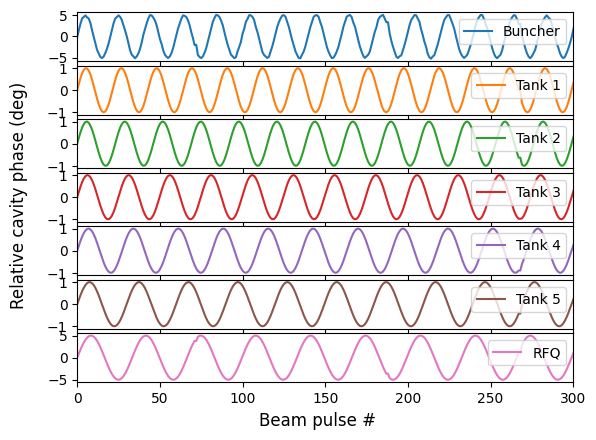

In [ ]:
# For demonstration: how are we changing cavity phases?
# Oscillating them all together in sinewaves with different frequencies
%matplotlib inline
fig,ax = plt.subplots(7,sharex=True)
colors = [p['color'] for p in plt.rcParams['axes.prop_cycle']]

for i, cav in enumerate(cavs[:7]):
    ax[i].plot(reference[0][cav],label='%s'%cavnames[i],c=colors[i])
    ax[i].legend(loc='upper right',bbox_to_anchor=(1,1))
    ax[i].set_xlim(0,300)

fig.supxlabel('Beam pulse #')
fig.supylabel('Relative cavity phase (deg)')
plt.subplots_adjust(wspace=0, hspace=0.1)

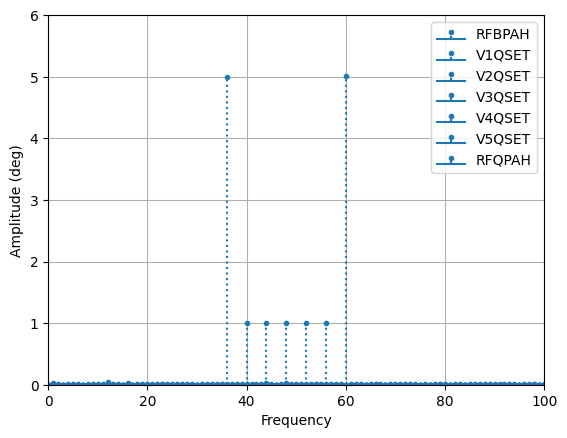

In [ ]:
# Sanity check in Fourier space: are cavity phases oscillating at the desired frequencies and amplitudes?
raw_ffts = apply_FFT(reference)

Nper = 4
Npt = 299
plot_fft(raw_ffts[0],cavs,Npt,Nper)

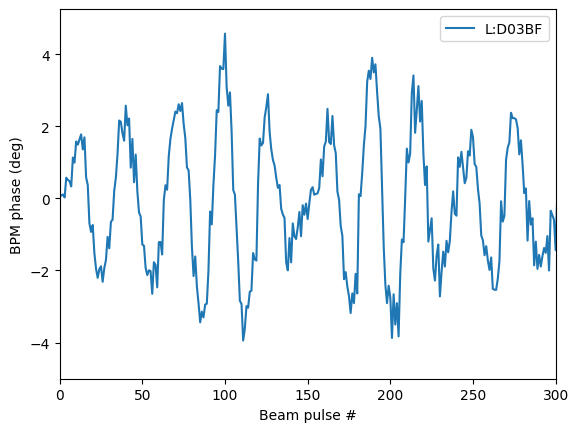

In [ ]:
# For demonstration purposes.
# What does the beam phase combined response look like? It is the combined effect of 7 cavities oscillating
# L:D03BF is the data from one sensor
plt.plot(reference[0]['L:D03BF'],label='L:D03BF')
#plt.plot(dfs[0]['L:D12BF'],label='L:D12BF') # different location
plt.xlim(0,300)
plt.xlabel('Beam pulse #')
plt.ylabel('BPM phase (deg)')
plt.legend()

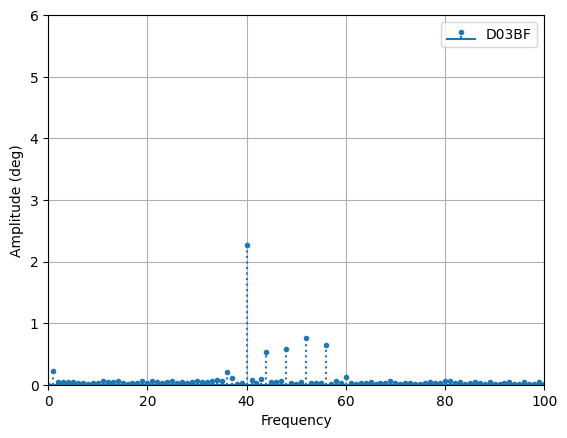

In [ ]:
# And here is the response in Fourier space.
# We see 7 peaks corresponding to the 7 cavities + noise
plot_fft(raw_ffts[0],['L:D03BF'],Npt,Nper)

In [ ]:
# select only relevant columns from dataframe
reference[0] = reference[0][cavs+BPM_list]

In [ ]:
# Calculate and plot response matrix: how beam phase changes in response to cavity phase change
refs = apply_FFT_filter(reference[0],cavs,BPM_list,tolerance=0.0001)
response_matrix = calc_response_matrix(refs,cavs)

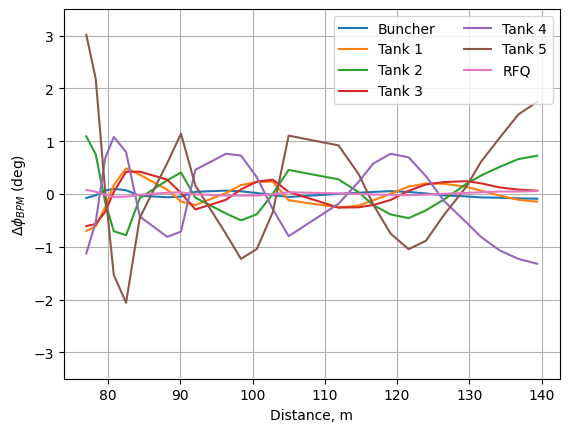

In [ ]:
%matplotlib inline
response_matrix_bpm = [r[BPM_list] for r in response_matrix]
plot_basis_vectors(response_matrix_bpm,cavs,range(len(response_matrix_bpm)))

In [ ]:
# Select 2 basis vectors out of the 7
show_basis_choices(response_matrix_bpm)
#basis_choice = select_basis(response_matrix_bpm,basis_choice_override=(0,1))
# we can force the choice of basis vectors. If not forced, it will look for "orthogonality" (see function body)
basis_choice = select_basis(response_matrix_bpm,basis_choice_override=None)

(0, 1) 0.27961901569415704
(0, 2) -0.8670116040802271
(0, 3) -0.1233579368323805
(0, 4) 0.9856910025722396
(0, 5) -0.7660174020816738
(0, 6) -0.8988990785786257
(1, 2) -0.7080716536561765
(1, 3) 0.9113739698257175
(1, 4) 0.36012551941067195
(1, 5) -0.8236282956598568
(1, 6) -0.6520936324218883
(2, 3) -0.369380052285205
(2, 4) -0.9109201271218615
(2, 5) 0.9812757202613248
(2, 6) 0.9811486147873665
(3, 4) -0.044271676425855215
(3, 5) -0.5254332820524441
(3, 6) -0.3013609853235986
(4, 5) -0.8245456014727126
(4, 6) -0.9210502116687425
(5, 6) 0.9515624705818239


In [ ]:
print(basis_choice)

(3, 4)


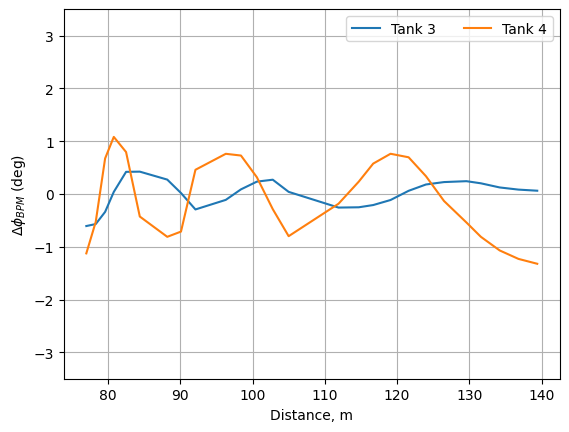

In [ ]:
# Sanity check
plot_basis_vectors(response_matrix_bpm,cavs,list(basis_choice))

In [ ]:
### Fitting with basis vectors demonstration
# Below we show several tests of the 2-vector fitting

# Test 1: 1-step drift compensation
# Fitting data from Feb 15 and Feb21 to return to Feb 08 state
# Reference file: Feb 29 (I think?)
path = "PhaseCompensation/"
dates = ["20240208_","20240215_","20240215_","20240221_","20240221_"]
times = ["163623_nominal",'143017_nominal2',
         "155508_dailyCorrFeb8_positive","161542_nominal2","162307_dailyCorrFeb8_negative2"]
files = ['%s%s%s.csv'%(path,d,t) for (d,t) in zip(dates,times)]
lbls = ['Feb 08 nominal','Feb 15 relative','Feb 15 corrected','Feb 21 relative','Feb 21 corrected']


'''
# Test 2: 1-step compensation of upstream fluctuation
# Reference file Feb 15
date="20240215_"
lbls = ['Nominal','RFQ +15deg','RFQ Compensated','T1+4deg','T1 Compensated']
times = ['132713_nominal_1000evt','133256_RFQplus15deg','134353_FullyCompensatedT4T5',
         '143412_T1plus4deg','144019_T1FullyCompensatedT4T5']
files = [r'%s%s%s.csv'%(filepath,date,t) for t in times]


# Test 3: multi-step compensation of upstream fluctuations
# Reference file April 10
date = '20240410_'
lbls = ['Nominal','Buncher+20deg','Compensated step 1','Step 2','Step 3','Step 4']
times = ['151457','152154','155113','160055','160739','161432']
files = [r'%s%s%s.csv'%(filepath,date,t) for t in times]
'''

dfs = load_BPMphase_data_multi(cavs_both,files,devices_to_drop,scan=False)


In [ ]:
means = [df[BPM_list].mean() for df in dfs]
stds = [df[BPM_list].std() for df in dfs] #normalized by N-1. Use ddof=0 to normalize by N
#should I be using SEM instead of STD?

In [ ]:
# Calculate difference from nominal
diffs = [m - means[0] for m in means]
errs = [np.sqrt(s**2 + stds[0]**2) for s in stds]

In [ ]:
dfs[3].columns

Index(['L:RFQPAH', 'L:RFBPAH', 'L:V1QSET', 'L:V2QSET', 'L:V3QSET', 'L:V4QSET',
       'L:V5QSET', 'L:V1SQ', 'L:V2SQ', 'L:V3SQ', 'L:V4SQ', 'L:V5SQ', 'L:D02BF',
       'L:D03BF', 'L:D11BF', 'L:D12BF', 'L:D13BF', 'L:D21BF', 'L:D22BF',
       'L:D23BF', 'L:D31BF', 'L:D32BF', 'L:D33BF', 'L:D34BF', 'L:D41BF',
       'L:D42BF', 'L:D43BF', 'L:D51BF', 'L:D52BF', 'L:D53BF', 'L:D54BF',
       'L:D61BF', 'L:D62BF', 'L:D63BF', 'L:D64BF', 'L:D71BF', 'L:D72BF',
       'L:D73BF', 'L:D74BF'],
      dtype='object')

In [ ]:
# Calculate phase setting changes

#meanrf = [df[cavs].mean() for df in dfs]
#deltarf = [mrf - meanrf[0] for mrf in meanrf]
#print([drf[cavs] for drf in deltarf[1:]])

AFNOModel1D(
  (afno1d): AFNO1D()
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

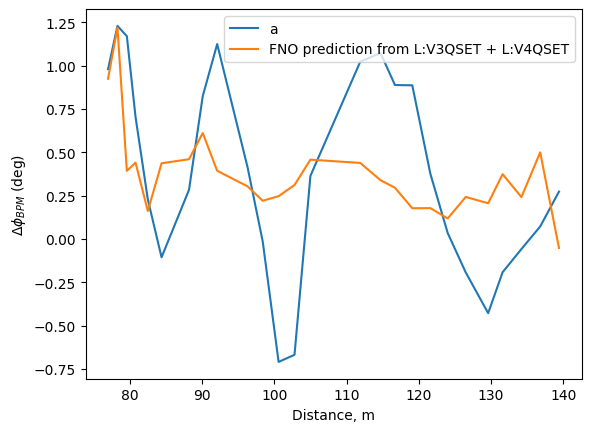

In [ ]:
plot_fit_traj(cavs,diffs[1],basis_choice,response_matrix,'a')

AFNOModel1D(
  (afno1d): AFNO1D()
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

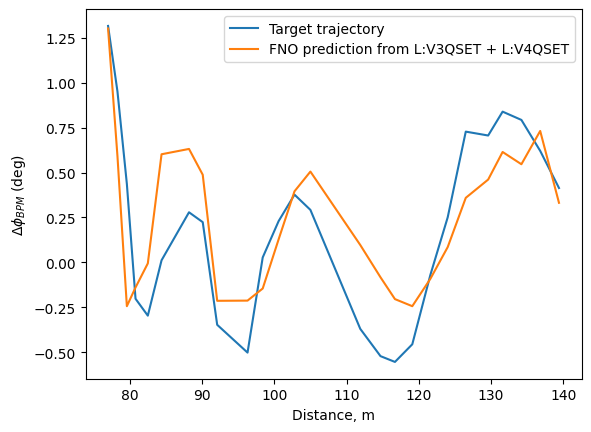

In [ ]:
plot_fit_traj(cavs,diffs[-1],basis_choice,response_matrix)

In [ ]:
# Metrics
for i,(diff,err) in enumerate(zip(diffs,errs)):
    print(r'%s mean'%lbls[i],diff.mean())
    print(r'%s STD'%lbls[i],diff.std())
    print(r'%s err'%lbls[i],err.mean())
    print(r'%s err/sqrt(N)'%lbls[i],err.mean()/np.sqrt(dfs[i].shape[0]))

Feb 08 nominal mean 0.0
Feb 08 nominal STD 0.0
Feb 08 nominal err 0.5028825624327904
Feb 08 nominal err/sqrt(N) 0.015910500168586278
Feb 15 relative mean 0.3686971789999088
Feb 15 relative STD 0.57972567773329
Feb 15 relative err 0.5173629778698481
Feb 15 relative err/sqrt(N) 0.016368640238382984
Feb 15 corrected mean 0.29826138734982727
Feb 15 corrected STD 0.31536004989514105
Feb 15 corrected err 0.5132486557362268
Feb 15 corrected err/sqrt(N) 0.016230347581461215
Feb 21 relative mean -0.03217693897229189
Feb 21 relative STD 1.387380506937479
Feb 21 relative err 0.5363418575024448
Feb 21 relative err/sqrt(N) 0.016960618741931936
Feb 21 corrected mean 0.19915923755034998
Feb 21 corrected STD 0.5138264903374351
Feb 21 corrected err 0.5293409467416688
Feb 21 corrected err/sqrt(N) 0.01674760640263509


(-4.0, 4.0)

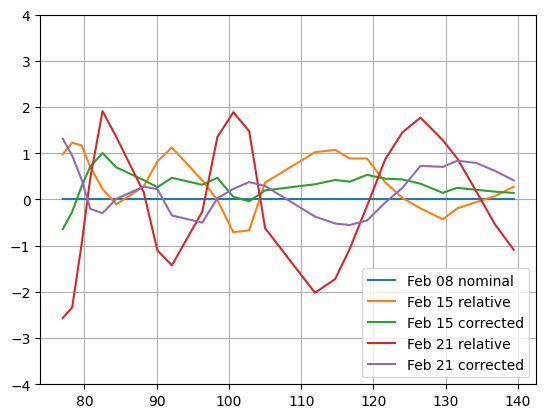

In [ ]:
#%matplotlib widget
#[plt.errorbar(dist_data,diff,yerr=err,label=lbls[i]) for i,(diff,err) in enumerate(zip(diffs,errs))];
[plt.plot(dist_data,diff,label=lbl) for (diff,lbl) in zip(diffs[:],lbls[:])];
plt.legend()
plt.grid()
plt.ylim(-4,4)